# Do left-handed people really die young?

# 1. Project info

**Project title**: Do left-handed people really die young?

**Name:** Lina Tran, Joel Ostblom, Madeleine Bonsma-Fisher, Ahmed Hasan

**E-mail:** lina.mntran@gmail.com, joel.ostblom@gmail.com, m.bonsma@mail.utoronto.ca, ahmed.hasan@mail.utoronto.ca

**GitHub username**: linanmt, joelostblom, mbonsma, aays

**Link to prior writing**: [Lina](https://github.com/UofTCoders/studyGroup/blob/gh-pages/lessons/python/classes/Classes_in_Python.ipynb), [Joel](https://github.com/UofTCoders/rcourse/blob/master/lec02-basic-r.Rmd), [Madeleine](https://github.com/UofTCoders/rcourse/blob/master/lec07-pop-models.Rmd), [Ahmed](https://github.com/UofTCoders/studyGroup/blob/gh-pages/lessons/r/dplyrmagrittr/lesson.Rmd) 

**Short description**: Left-handed people are commonly believed to die younger than right-handed people. 
    This notebook outlines a simple statistical explanation for this alarming belief.

#### Long description ####

A [1991 study](https://www.nejm.org/doi/full/10.1056/NEJM199104043241418) reported that left-handed people die on average 9 years earlier than right-handed people. This result was much-disputed, and it turns out to be the result of a simple statistical mistake (described in this [BBC article](www.bbc.com/news/magazine-23988352)). The reported rates of left-handedness have increased from just 3% in the early 1900s to about 11% today, which means that older people are much more likely to be reported as right-handed than left-handed, and so looking at a sample of recently deceased people will have more old right-handers. In this Python project, we will explore the impact of this mistake using age distribution data to see if we can reproduce a difference in average age at death purely from the changing rates over time. This notebook uses `pandas` and Bayesian statistics to analyze the probability of being a certain age at death given that you are reported as left-handed or right-handed.

#### Datasets used ####

This project uses two datasets: [death distribution data](https://www.cdc.gov/nchs/data/statab/vs00199_table310.pdf) for the United States from the year 1999 (source website [here](https://www.cdc.gov/nchs/nvss/mortality_tables.htm)) and rates of left-handedness data from a [1992 paper by Gilbert and Wysocki](https://www.ncbi.nlm.nih.gov/pubmed/1528408). I scraped the death distribution data using [tabula](https://tabula.technology/) and saved the first three columns. I scraped data points approximately from Figure 2 in the Gilbert and Wysocki paper using this [web plot digitizer](https://apps.automeris.io/wpd/). 

Death distribution data:
`cdc_vs00199_table310.tsv`: https://gist.github.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec

Left-handedness data:
`lh_data.csv`: https://gist.github.com/mbonsma/8da0990b71ba9a09f7de395574e54df1

#### Assumed student background ####

The student can handle basic python control structures like `if` statements and `for` loops. The student has used `pandas` and can load in and inspect `csv` files. She knows how to select columns and subset rows using the `[]` operator and understand vectorized operators (like that `+` is vectorized). The student has produced line and scatter plots using `matplotlib`. The student is familiar with the concept of a probability distribution, knows how to calculate the mean of a probability distribution, and knows Bayes' rule for conditional probability.

---

## 1. Where are the old left-handed people?

A National Geographic survey in 1986 resulted in over a million responses that included age, sex, and hand preference for throwing and writing. Researchers Avery Gilbert and Charles Wysocki analyzed this data and noticed that rates of left-handedness were around 13% for people younger than 40 but decreased with age to about 5% by the age of 80. 

They concluded based on analysis of a subgroup of people who throw left-handed but write right-handed that this age-dependence was primarily due to changing social acceptibility of left-handedness. This means that the rates aren't a factor of *age* specifically but rather of the *year you were born*, and if the same study was done today, we should expect a shifted version of the same distribution as a function of age.

Ultimately, we'll see what effect this changing rate has on the apparent mean age of death of left-handed people, but let's start by plotting the rates of left-handedness as a function of age.


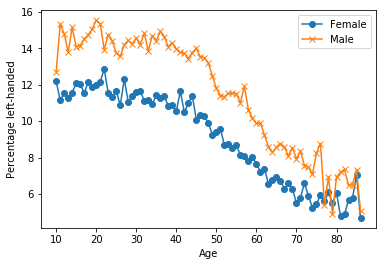

In [1]:
# load the left-handedness data and create a scatter plot

import pandas as pd
from matplotlib import pyplot as plt

data_url = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url, sep = ',')

# this makes the plot appear in the notebook
%matplotlib inline

fig, ax = plt.subplots()
ax.plot('Age', 'Female', data = lefthanded_data, marker='o')
ax.plot('Age','Male', data = lefthanded_data, marker = 'x')

ax.legend()
ax.set_xlabel("Age")
ax.set_ylabel("Percentage left-handed")

## 2. Rates of left-handedness over time

Let's convert this data into a plot of the rates of left-handedness as a function of the year you were born, and average over male and female to get a single rate for both sexes.

We want the percentage of people alive in 1986 who are left-handed as a function of the year they were born. 

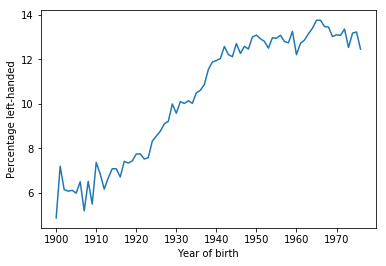

In [2]:
# create a new column for birth year of each age
lefthanded_data['Year'] = 1986 - lefthanded_data['Age'] # the study was done in 1986

# create a new column for the average of male and female
lefthanded_data['Mean_lh'] = lefthanded_data[['Female', 'Male']].mean(axis = 1)

fig, ax = plt.subplots()
ax.plot('Year', 'Mean_lh', data = lefthanded_data)
ax.set_xlabel("Year of birth")
ax.set_ylabel("Percentage left-handed")

## 3. Applying Bayes' rule

**Bayes' rule** or **Bayes' theorem** is a statement about conditional probability. The probability of outcome or event $A$, given that outcome or event $B$ has happened (or is true) is not the same as the probability of outcome $B$ given that outcome $A$ has happened. We need to take into account the **prior** probability that $A$ has happened ($P(A)$). Bayes' rule can be written as follows:

$$P(A | B) = \frac{P(B|A) P(A)}{P(B)}$$

The quantity we ultimately want to calculate is the probability of dying at a particular age $A$, *given that* your family thinks you are left-handed. Let's write this in shorthand as $P(A | LH)$. We also want the same quantity for right-handers: $P(A | RH)$. We can figure out or approximate the other three quantities to find out what difference in age of death we might expect purely from the changing rates of left-handedness plotted above.

Here's Bayes' rule in the context of our discussion:


$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$

$P(LH | A)$ is the probability that you are left-handed *given that* you died at age $A$. $P(A)$ is the overall probability of dying at age $A$, and $P(LH)$ is the overall probability of being left-handed. We will now calculate each of these three quantities. 

In [3]:
# create a function for P(LH | A)

def P_lh_given_A(age_of_death, study_year = 1990):
    """
    P(LH | age of death), calculated based on the reported rates of left-handedness
    The original study that reported a 9-year age of death difference was done in 1990. 
    """
    
    # Assume the rates before and after the start of the dataset are the mean of the 10 neighbouring points
    early_1900s_rate = lefthanded_data['Mean_lh'][-10:].mean()
    late_1900s_rate = lefthanded_data['Mean_lh'][:10].mean()
    
    youngest_age = study_year - 1986 + 10 # the youngest age in the dataset is 10
    oldest_age = study_year - 1986 + 86 # the oldest age in the datset is 86
    
    if age_of_death < youngest_age:
        return late_1900s_rate
    elif age_of_death > oldest_age:
        return early_1900s_rate
    else:
        return lefthanded_data.loc[lefthanded_data['Year'] == study_year - age_of_death]['Mean_lh']
